In [1]:
##Importing libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
import itertools

In [4]:
def initialize_model_parameters(X_train, y_train):
    #defining the model architecture
    inputlayer_neurons = X_train.shape[1]  #number of features in data set
    #print(inputLayer_neurons)
    hiddenlayer1_neurons = 1000  #number of neurons in hidden layer 1
    hiddenlayer2_neurons = 1000  #number of neurons in hidden layer 2
    outputlayer_neurons = y_train.shape[1]  #number of neurons at output layer
    #outputlayer_neurons = 1  #number of neurons at output layer
   
    #initializing the weight and bias for first hidden layer
    wh1 = np.random.uniform(size=(inputlayer_neurons, hiddenlayer1_neurons))
    bh1 = np.zeros(hiddenlayer1_neurons)
    
    #initializing the weight and bias for second hidden layer
    wh2 = np.random.uniform(size=(hiddenlayer1_neurons, hiddenlayer2_neurons))
    bh2 = np.zeros(hiddenlayer2_neurons)
    
    #initializing the weight and bias for output layer
    wh3 = np.random.uniform(size=(hiddenlayer2_neurons, outputlayer_neurons))
    bh3 = np.zeros(outputlayer_neurons)
    
    print("W1 shape : " + str(wh1.shape) + ", b1 shape : " + str(bh1.shape))
    print("W2 shape : " + str(wh2.shape) + ", b2 shape : " + str(bh2.shape))
    print("W3 shape : " + str(wh3.shape) + ", b3 shape : " + str(bh3.shape))
    
    model = { 'wh1':wh1, 'bh1':bh1, 'wh2':wh2, 'bh2':bh2, 'wh3':wh3, 'bh3':bh3 }
    
    return model

def relu_function(Z):
    return np.maximum(0,Z)

def relu_derivative(Z):
    Z[Z<=0] = 0
    Z[Z>0] = 1
    return Z

def forward_propagation(X, y, model):
    #loading parameters from model
    wh1, bh1, wh2, bh2, wh3, bh3 = model['wh1'], model['bh1'], model['wh2'], model['bh2'], model['wh3'], model['bh3']
    
    #performing first linear step - hidden layer 1
    #z1 is the (dot product of input layer X and weights) + bias
    #putting z1 through activation function of first hidden layer
    a1 = X
    z1 = np.dot(a1, wh1) + bh1

    #performing second linear step - hidden layer 2
    #z2 is the (dot product of first hidden layer z1 and weights) + bias
    #putting z2 through activation function of second hidden layer
    a2 = relu_function(z1)
    z2 = np.dot(a2, wh2) + bh2
    
    #performing third linear step - output layer
    #z3 is the (dot product of second hidden layer z2 and weights) + bias
    #putting z3 through activation function of second hidden layer
    a3 = relu_function(z2)
    z3 = np.dot(a3, wh3) + bh3

    #print(z1.shape, a1.shape)
    #print(z2.shape, a2.shape)
    #print(z3.shape, a3.shape)
    
    fw_prop = {'z1':z1, 'a1':a1, 'z2':z2, 'a2':a2, 'z3':z3, 'a3':a3}
    
    return fw_prop

def backward_propagation(X, y, model, fw_prop):
    #loading parameters from model
    wh1, bh1, wh2, bh2, wh3, bh3 = model['wh1'], model['bh1'], model['wh2'], model['bh2'], model['wh3'], model['bh3']
    
    #loading parameters from forward propagation results
    z1, a1, z2, a2, z3, a3 = fw_prop['z1'], fw_prop['a1'], fw_prop['z2'], fw_prop['a2'], fw_prop['z3'], fw_prop['a3']
    #print(a3.shape)
    #backpropagation
    #z3_delta = (z3 - y) * relu_derivative(z3)                 # 80000 x 24
    z3_delta = (z3 - y)
    #print(z3_delta.shape)
    dwh3 = np.dot(a3.T, z3_delta)                              # 1000 x 24
    #print(dwh3.shape)
    dbh3 = np.sum(z3_delta, axis=0)                            # 1 x 24
    #print(dbh3.shape)

    z2_delta = np.dot(z3_delta, wh3.T) * relu_derivative(z2)   # 80000 x 1000
    dwh2 = np.dot(a2.T, z2_delta)                              # 1000 x 1000
    dbh2 = np.sum(z2_delta, axis=0)                            # 1 X 1000

    z1_delta = np.dot(z2_delta, wh2.T) * relu_derivative(z1)   # 80000 x 1000
    dwh1 = np.dot(X.T, z1_delta)                               # 101 x 1000
    dbh1 = np.sum(z1_delta, axis=0)                            # 1 X 1000 
    
    #print(dwh1.shape, dbh1.shape)
    #print(dwh2.shape, dbh2.shape)
    #print(dwh3.shape, dbh3.shape)
    
    gradients = {'dwh1':dwh1, 'dbh1':dbh1, 'dwh2':dwh2, 'dbh2':dbh2, 'dwh3':dwh3, 'dbh3':dbh3}
    
    return gradients

In [80]:
def train_neural_net(X_train, y_train, model):
    num_training_epoch = 100
    epoch = 0
    learning_rate = 1e-6
    batch_size = 128
    #loading parameters from model
    wh1, bh1, wh2, bh2, wh3, bh3 = model['wh1'], model['bh1'], model['wh2'], model['bh2'], model['wh3'], model['bh3']
    train_mae_list = []

    for epoch in range(num_training_epoch):
        # shuffle to prevent repeating update cycles
        X, Y = shuffle(X_train, y_train)
        #learning_rate_decay = learning_rate/num_training_epoch
        learning_rate_decay = learning_rate / (epoch+1)

        # Forward Propagation
        if epoch % 10 == 0:
            learning_rate /= 2
            #learning_rate_decay = learning_rate / (epoch+1)
            
        fw_prop = forward_propagation(X, Y, model)
        z1, a1, z2, a2, z3, a3 = fw_prop['z1'], fw_prop['a1'], fw_prop['z2'], fw_prop['a2'], fw_prop['z3'], fw_prop['a3']
        
        #loss = np.mean((np.absolute(z3 - y_train)).mean(axis=1))
        loss = mean_absolute_error(z3, Y)
        #loss = (np.sum(np.absolute(z3 - Y)))/len(Y)
        loss /= 100
        #loss = np.mean(np.absolute(z3 - y_train))
        train_mae_list = np.append(train_mae_list, [loss])
        
        # Back Propagation
        bw_prop = backward_propagation(X_train, y_train, model, fw_prop)
        dwh1, dbh1, dwh2, dbh2, dwh3, dbh3 = bw_prop['dwh1'], bw_prop['dbh1'], bw_prop['dwh2'], bw_prop['dbh2'], bw_prop['dwh3'], bw_prop['dbh3']
        
        # Update parameters
        wh1 = wh1 - learning_rate_decay * dwh1
        bh1 = bh1 - learning_rate_decay * dbh1
        wh2 = wh2 - learning_rate_decay * dwh2
        bh2 = bh2 - learning_rate_decay * dbh2
        wh3 = wh3 - learning_rate_decay * dwh3
        bh3 = bh3 - learning_rate_decay * dbh3
    
        model = { 'wh1':wh1, 'bh1':bh1, 'wh2':wh2, 'bh2':bh2, 'wh3':wh3, 'bh3':bh3 }
    
    return train_mae_list, model, fw_prop

def plot_figure(error_train, error_test, error_val):
    print('Neural Network Loss : ')
    for i in range(100):
        print("Epoch " + str(i) + " : Train_MAE = " + str(np.round(error_train[i])) + ", Test_MAE : " + str(np.round(error_test[i])) + ", Validation_MAE : " + str(np.round(error_val[i])))
    
    plt.figure(figsize=(12,8))
    plt.plot(error_train, label='Training MAE')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.legend(loc='best',ncol=1, frameon=True, shadow=True, fontsize=14)
    plt.show()
    
    plt.figure(figsize=(12,8))
    plt.plot(error_test, label='Testing MAE')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.legend(loc='best',ncol=1, frameon=True, shadow=True, fontsize=14)
    plt.show()
    
    plt.figure(figsize=(12,8))
    plt.plot(error_val, label='Validation MAE')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.legend(loc='best',ncol=1, frameon=True, shadow=True, fontsize=14)
    plt.show()

In [2]:
data = np.load('Data2.npz')
print(data.files)
Policy = data['PdPa']
Value = data['V']
print(Policy.shape)
print(Value.shape)

['PdPa', 'V']
(100000, 101)
(100000, 24)


In [3]:
#Divide dataset into train, test and validation
num_val = 10000
batch_size = 128
Policy_val = Policy[0:num_val]
Policy_test = Policy[num_val:2*num_val]
Policy_train = Policy[2*num_val:]

Value_val = -(Value[0:num_val])
Value_test = -(Value[num_val:2*num_val])
Value_train = -(Value[2*num_val:])

X_train, X_test, X_val = Policy_train, Policy_test, Policy_val
y_train, y_test, y_val = Value_train, Value_test, Value_val

#X_train = preprocessing.normalize(X_train)

print('X_train shape : ', X_train.shape)
print('X_test shape : ', X_test.shape)
print('X_val shape : ', X_val.shape)
print('y_train shape : ', y_train.shape)
print('y_test shape : ', y_test.shape)
print('y_val shape : ', y_val.shape)


X_train shape :  (80000, 101)
X_test shape :  (10000, 101)
X_val shape :  (10000, 101)
y_train shape :  (80000, 24)
y_test shape :  (10000, 24)
y_val shape :  (10000, 24)


In [5]:
model = initialize_model_parameters(X_train, y_train)

W1 shape : (101, 1000), b1 shape : (1000,)
W2 shape : (1000, 1000), b2 shape : (1000,)
W3 shape : (1000, 24), b3 shape : (24,)


In [73]:
fw_prop = forward_propagation(X_train, y_train, model)

In [74]:
grad = backward_propagation(X_train, y_train, model, fw_prop)

Neural Network Loss : 
Epoch 0 : Train_MAE = 8662.0, Test_MAE : 627.0, Validation_MAE : 627.0
Epoch 1 : Train_MAE = 693.0, Test_MAE : 621.0, Validation_MAE : 621.0
Epoch 2 : Train_MAE = 679.0, Test_MAE : 619.0, Validation_MAE : 619.0
Epoch 3 : Train_MAE = 670.0, Test_MAE : 618.0, Validation_MAE : 618.0
Epoch 4 : Train_MAE = 663.0, Test_MAE : 617.0, Validation_MAE : 617.0
Epoch 5 : Train_MAE = 658.0, Test_MAE : 617.0, Validation_MAE : 617.0
Epoch 6 : Train_MAE = 654.0, Test_MAE : 616.0, Validation_MAE : 616.0
Epoch 7 : Train_MAE = 650.0, Test_MAE : 616.0, Validation_MAE : 616.0
Epoch 8 : Train_MAE = 647.0, Test_MAE : 615.0, Validation_MAE : 615.0
Epoch 9 : Train_MAE = 644.0, Test_MAE : 615.0, Validation_MAE : 615.0
Epoch 10 : Train_MAE = 641.0, Test_MAE : 615.0, Validation_MAE : 615.0
Epoch 11 : Train_MAE = 639.0, Test_MAE : 614.0, Validation_MAE : 614.0
Epoch 12 : Train_MAE = 638.0, Test_MAE : 614.0, Validation_MAE : 614.0
Epoch 13 : Train_MAE = 637.0, Test_MAE : 614.0, Validation_MAE 

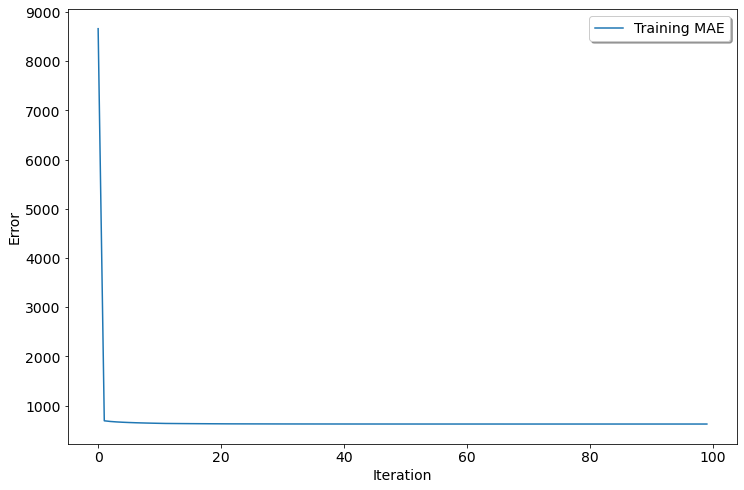

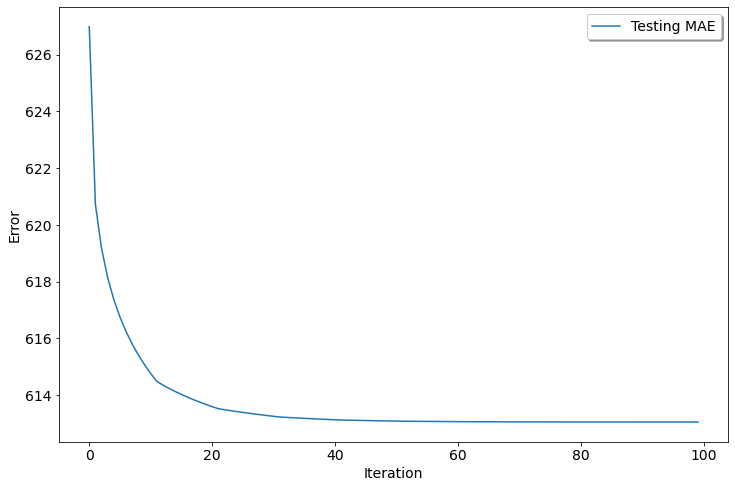

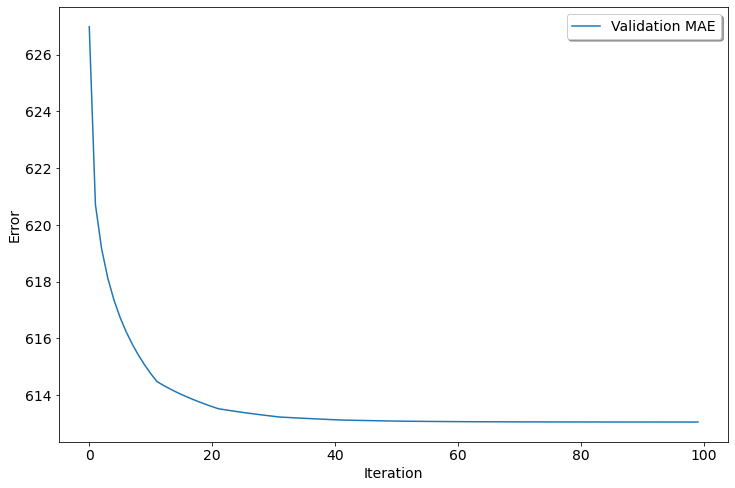

In [81]:
error_train, model_train, fw_prop_train = train_neural_net(X_train, y_train, model)
error_test, model_test, fw_prop_test = train_neural_net(X_test, y_test, model_train)
error_val, model_val, fw_prop_val = train_neural_net(X_val, y_val, model_train)

plot_figure(error_train, error_test, error_val)